In [ ]:
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyr)
library(RCurl)
library(ggthemes)
library(ggrepel)
library("rnaturalearth")
library("rnaturalearthdata")
library("sf")
library(rgeos)
library(tmap)
library(RColorBrewer)
library(cowplot)

In [11]:
# DATA URL

covid_url = getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv") 
recovered_url = getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
deaths_url = getURL("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggthemes’:

    theme_map



## Downloading and processing data
1. Datset consist of 3 main files for Confirmed Cases, Deaths and Recovered. 
2. We can load them directly using RCurl library
3. We need to make data tidy and merge all three dataset into a single data.frame

In [2]:
# When reading the raw data files, the dates come as columns and are not properly formatted
# This function will convert a string from the raw format into the format dd-mm-yyyy which can be read and converted to a Date object
convertToDate2<-function(x){     

  month_day=do.call(rbind,str_split(x,"\\."))
  month_day[,1] %>% str_replace(pattern ="X",replacement="") ->month
  month_day[,3] %>% str_replace(pattern ="20",replacement="2020") ->year

  return(paste(year, month, month_day[,2],sep="-"))
}

# Load files
covid_data = read.csv(text = covid_url)
covid_deaths = read.csv(text = deaths_url)
covid_recovered = read.csv(text = recovered_url)

# Convert the date format
names(covid_data)[-c(1:4)] = convertToDate2(names(covid_data)[-c(1:4)])
names(covid_deaths)[-c(1:4)] = convertToDate2(names(covid_deaths)[-c(1:4)])
names(covid_recovered)[-c(1:4)] = convertToDate2(names(covid_recovered)[-c(1:4)])

# Use gather to make tidy data frames
covid_recovered %>% gather('Date','Cases',-c(Province.State,Country.Region,Lat,Long)) ->tidy_recovered
covid_data %>% gather('Date','Cases',-c(Province.State,Country.Region,Lat,Long)) ->tidy_cases
covid_deaths %>% gather('Date','Cases',-c(Province.State,Country.Region,Lat,Long)) ->tidy_deaths

# Convert date to Date objects (easier to use)
tidy_cases$Date = as.Date(tidy_cases$Date)
tidy_deaths$Date = as.Date(tidy_deaths$Date)
tidy_recovered$Date = as.Date(tidy_recovered$Date)

# Rename our variables of interest
names(tidy_deaths)[6]<-'Deaths'
names(tidy_recovered)[6]<-'Recovered'

# Merge into single dataset 
covid19_dataset <- merge(merge(tidy_cases,tidy_deaths), tidy_recovered) 



## The tidy dataset
After processing, the dataset includes all countries and the number of confirmed, death and recovered cases for each day from 22th-Jan to present day (22th-March). Since this script read the data from the URL, which is updated every few hours, the data frame should contain the most up-to-date numbers. Since the number of cases increases by the hour, there might be a delay when comparing with a real-time count. 

In [21]:
# Let's see how it looks
covid19_dataset

Province.State,Country.Region,Lat,Long,Date,Cases,Deaths,Recovered
<fct>,<fct>,<dbl>,<dbl>,<date>,<int>,<int>,<int>
,Afghanistan,33,65,2020-01-22,0,0,0
,Afghanistan,33,65,2020-01-23,0,0,0
,Afghanistan,33,65,2020-01-24,0,0,0
,Afghanistan,33,65,2020-01-25,0,0,0
,Afghanistan,33,65,2020-01-26,0,0,0
,Afghanistan,33,65,2020-01-27,0,0,0
,Afghanistan,33,65,2020-01-28,0,0,0
,Afghanistan,33,65,2020-01-29,0,0,0
,Afghanistan,33,65,2020-01-30,0,0,0


## Fig1. World distribution of COVID19 cases 
To visualize the dataset as a world heatmap we first summarise each country as their current number of confirmed cases. We can use the library rnaturalearth to retrieve a dataframe with geographic information about all countries plus additional information such as estimated population, GDP, etc. 

Warning message:
“The shape . is invalid. See sf::st_is_valid”

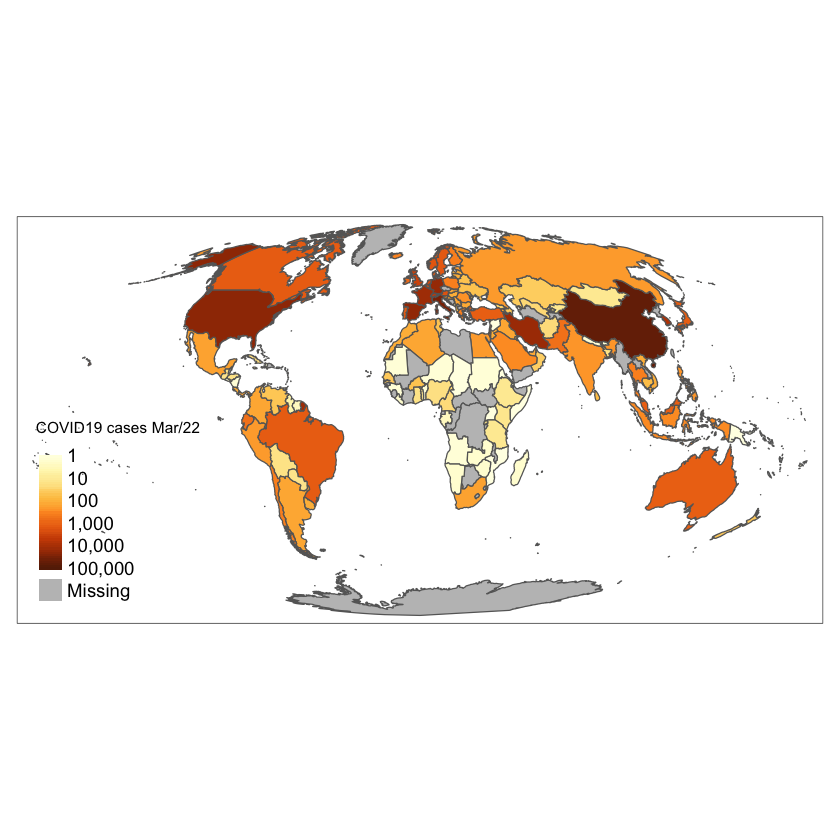

In [25]:

# Retrive World information 
world <- ne_countries(scale = "medium", returnclass = "sf")
world_moll = st_transform(world, crs = "+proj=moll")

# get the total (max) cases per country for map heatmap
covid19_dataset %>%  group_by(Country.Region,Date) %>% 
                    summarize(Cases = sum(Cases),Deaths=sum(Deaths),Recovered = sum(Recovered))  %>% 
                    group_by(Country.Region) %>% 
                    summarize(Cases = max(Cases),Deaths = max(Deaths),Recovered = max(Recovered)) %>% 
                    arrange(desc(Cases)) -> static_data

# Some names for countries don't agree between the COVID data and the World data so we replace them
static_data$Country.Region %>% str_replace("US","United States") %>% 
                            str_replace("Korea, South","Korea") -> static_data$Country.Region

# 'name' will be the variable for the country's name
names(static_data)[1] = 'name'
# merge dataset by 'name'
left_join(world_moll, static_data, by='name') -> world_covid


world_covid %>% mutate(COVID_cases_log = log10(Cases)) %>% 
                tm_shape() + 
                tm_fill(col="Cases",breaks = 10^(0:5),
                        title = paste("COVID19 cases",format(Sys.Date(),'%b/%d')), 
                        legend.format =list(format="f", big.mark = ',',scientific = T),style ="cont") + 
                tm_borders()  + 
                tm_layout(legend.outside = F,legend.text.size = 0.7,legend.title.size = 0.7)

# Analysis by country
For some countries, the dataset contains data at the level of States of Cities. However, we can first take a look at the spread of COVID-19 for different countries. We normalized the data by the population of each country and then aligned the time series of different countries relative to the day in which they passed the threshold of 1 case per million habitants. 

In [4]:
# Group data by country and ADD the numbers (we loose the information by State, City)
covid19_dataset %>% group_by(Country.Region,Date) %>% 
                    summarise( Cases = sum(Cases), Deaths = sum(Deaths),Recovered = sum(Recovered) ) -> covid19_countries

# rename the variable for the country's name (for compatibility with the World dataset)
names(covid19_countries)[1] = 'name'
# Fix the names (for compatibility with the World dataset)
covid19_countries$name%>% str_replace("US","United States") %>% str_replace("Korea, South","Korea") -> covid19_countries$name

# Join the COVID19 data with World data for normalization by country's population 
left_join(covid19_countries, world_moll %>% select(name,pop_est,region_wb),by='name') -> covid19_countries

# Normalize Cases and Deaths by million inhabitants
covid19_countries %>% mutate(Cases_pm = Cases / (pop_est/10^6) ) -> covid19_countries
covid19_countries %>% mutate(Death_pm = Deaths / (pop_est/10^6) ) -> covid19_countries



In [48]:

alignData<-function(covid19_countries, by='Cases', since=100, plot_countries  = c()){

    if(by=='Cases'){
        covid19_countries %>% group_by(name) %>% filter(name %in% plot_countries) %>% 
        filter(Cases_pm >=since) %>% top_n(1,-Cases_pm) %>% group_by(name) %>% top_n(1,Date) -> Dates_of_1Casepm
    }else if(by=='Deaths'){
        covid19_countries %>% group_by(name) %>% filter(name %in% plot_countries) %>% 
        filter(Deaths >=since) %>% top_n(1,-Deaths) %>% group_by(name) %>% top_n(1,Date) -> Dates_of_1Casepm
    }

    aligned_data = covid19_countries

    aligned_data[,"Diff"] <- NA
    for(i in 1:dim( Dates_of_1Casepm )[1] ){
       aligned_data[aligned_data$name==Dates_of_1Casepm$name[i],]$Diff =  aligned_data$Date[aligned_data$name==Dates_of_1Casepm$name[i]] - Dates_of_1Casepm$Date[i]   
    }

    if(by=='Cases'){
        return(aligned_data %>%  filter(name %in% plot_countries) %>% filter(Cases_pm >=since))
    }else if(by=='Deaths'){
        return(aligned_data %>%  filter(name %in% plot_countries) %>% filter(Deaths >since))
    }
}

<br><br><br><br>
## Fig 2. Cases per million habitants for countries with more than 1k cases 
After filtering for countries with at least 1000 cases, we can plot the data relative to the day when different countries passed the 1 COVID-19 case per million habitants. 

In [49]:
# Filter for countries with at least 1000 cases 

static_data %>% filter(Cases >=1000) %>% pull(name) -> plot_countries
static_data %>% filter(Deaths >=10) %>% pull(name) -> plot_countries_deaths


# Align relative to the day of the 1 case p/million 
aligned_test = alignData(covid19_countries, by="Cases",since = 1,plot_countries = plot_countries)
aligned_deaths = alignData(covid19_countries, by ="Deaths",since = 10, plot_countries = plot_countries_deaths)

Warning message:
“Removed 7 rows containing missing values (geom_path).”Warning message:
“Removed 7 rows containing missing values (geom_point).”

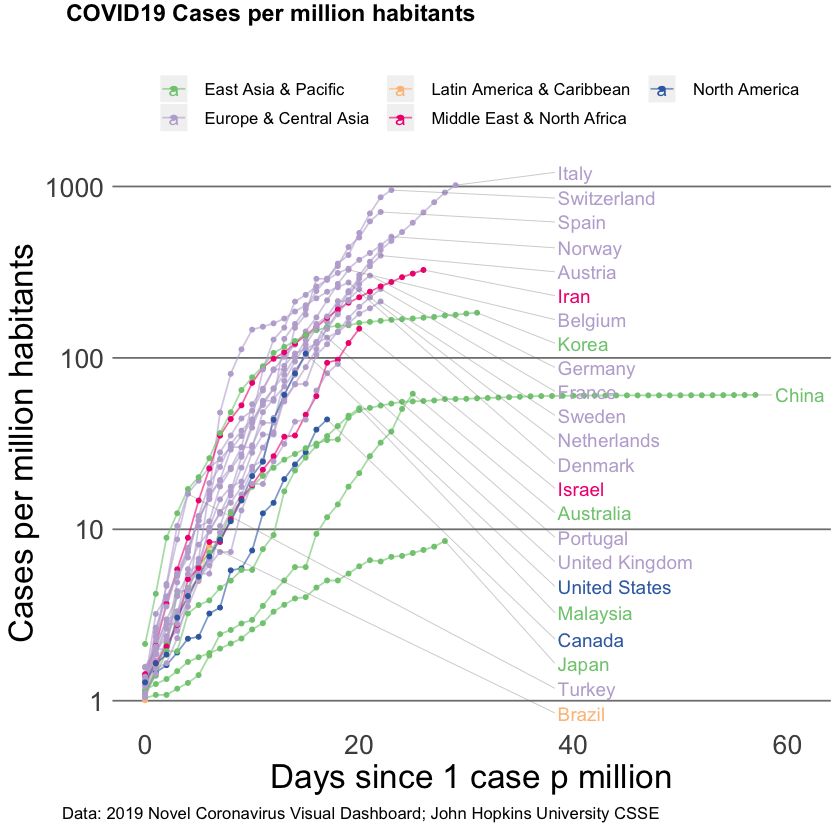

In [41]:
colorCount = length(unique(world_moll$region_wb))
getPalette = colorRampPalette(brewer.pal(8, "Accent"))
colors = getPalette(colorCount)
colors = colors[c(1,2,3,6,5,4,7,8)]


aligned_test %>% ggplot(aes(x =Diff,y = Cases_pm,color=region_wb,group=name)) + 
    geom_path(alpha = 0.6) + geom_point(size = 1)  + 
    geom_text_repel(data =aligned_test %>% filter(Date == last(Date)), 
                    aes(label = unique(aligned_test$name)), 
                    nudge_x =2, 
                    xlim = c(max(aligned_test$Diff[aligned_test$name=='Korea']) + 7,NA) , 
                    hjust = 0, direction ='y',segment.size = 0.1, 
                    segment.colour = 'gray50',size = 4)  + 
    xlim(0,max(aligned_test$Diff)+4)  + 
    scale_y_continuous(trans = 'log10',name = "Cases per million habitants") + 
    scale_color_manual(values= colors) + 
    theme(legend.position  ='top', 
          legend.title = element_blank(), 
          legend.box = 'horizontal',
          legend.text = element_text(size = 10)) + 
    guides(col = guide_legend(nrow = 2)) + 
    theme(text =element_text(size = 20)) + 
    theme(panel.grid.minor = element_blank(),
          panel.grid.major = element_line(color = "gray50", size = 0.5), 
          panel.grid.major.x = element_blank(), 
          panel.background = element_blank(),
          line= element_blank(), 
          panel.border = element_blank()) + 
     
    xlab("Days since 1 case p million") + ggtitle("COVID19 Cases per million habitants\n") + 
  theme(plot.title = element_text(hjust = -0.15, 
                                  vjust=2.12, 
                                  colour="black",
                                  size = 14,
                                  face="bold"))-> p  
    p = add_sub(p,"Data: 2019 Novel Coronavirus Visual Dashboard; John Hopkins University CSSE",
                x = -0.07,
                hjust = 0,
                fontface = "plain",
                size= 10) 
    ggdraw(p)


We can see that most European countries reached hundres of cases p/m within 20 days. Countries in Asia, however, seemed to have a lower rate of spreading. Brazil is the only country from South America that has reached more than 1000 confirmed cases. 


<br><br><br><br>
## Fig 3. Deaths since day of 10th death 


Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

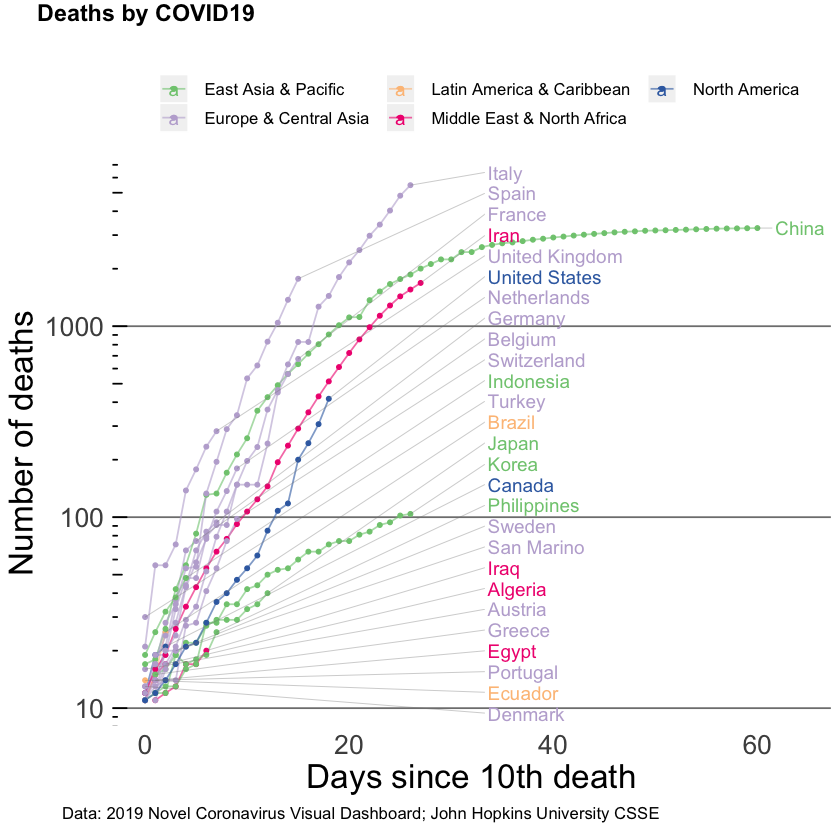

In [50]:

aligned_deaths %>% ggplot(aes(x =Diff,y = Deaths,color=region_wb,group=name)) + 
    geom_path(alpha = 0.6) + geom_point(size = 1)  + 
    geom_text_repel(data =aligned_deaths %>% filter(Date == last(Date)), 
                    aes(label = unique(aligned_deaths$name)), 
                    nudge_x =2, 
                    xlim = c(max(aligned_deaths$Diff[aligned_deaths$name=='Korea']) + 7,NA) , 
                    hjust = 0, direction ='y',segment.size = 0.1, 
                    segment.colour = 'gray50',size = 4)  + 
    xlim(0,max(aligned_deaths$Diff)+4)  + 
    scale_y_continuous(trans = 'log10',name = "Number of deaths") + 
    annotation_logticks(sides = 'l') +
    scale_color_manual(values= colors) + 
    theme(legend.position  ='top', 
          legend.title = element_blank(), 
          legend.box = 'horizontal',
          legend.text = element_text(size = 10)) + 
    guides(col = guide_legend(nrow = 2)) + 
    theme(text =element_text(size = 20)) + 
    theme(panel.grid.minor = element_blank(),
          panel.grid.major = element_line(color = "gray50", size = 0.5), 
          panel.grid.major.x = element_blank(), 
          panel.background = element_blank(),
          line= element_blank(), 
          panel.border = element_blank()) + 
     
    xlab("Days since 10th death") + ggtitle("Deaths by COVID19\n") + 
  theme(plot.title = element_text(hjust = -0.15, 
                                  vjust=2.12, 
                                  colour="black",
                                  size = 14,
                                  face="bold"))-> p  
    p = add_sub(p,"Data: 2019 Novel Coronavirus Visual Dashboard; John Hopkins University CSSE",
                x = -0.07,
                hjust = 0,
                fontface = "plain",
                size= 10) 
    ggdraw(p)


# Analysis by State in the USA
Here we will compare three regions from the United States that have been particularly affected by COVID19: Seattle, New York and California. 
For this we need: 
1. A map of the Unitated States
2. Analyse the data by Province/State (for those available)